<a href="https://colab.research.google.com/github/jwasswa2023/Physpropnet/blob/main/Composite_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

# ========= Settings =========
INPUT_CSV = "/content/SUMMARY 2.csv"

# weighting schemes to report (must sum to ~1; they’ll be renormalized anyway)
WEIGHT_SCHEMES = {
    "equal"        : {"R2":0.25, "MAE":0.25, "RMSE":0.25, "Time":0.25},
    "accuracyheavy": {"R2":0.50, "MAE":0.25, "RMSE":0.20, "Time":0.05},
    "erroronly"    : {"R2":0.40, "MAE":0.30, "RMSE":0.30, "Time":0.00},
    "speedaware"   : {"R2":0.25, "MAE":0.20, "RMSE":0.20, "Time":0.35},
}

# random-weight sensitivity: draw K sets of weights from Dirichlet
RANDOM_WEIGHT_DRAWS = 200
DIRICHLET_ALPHA = np.array([1,1,1,1])  # uninformative

# ========= Load & clean =========
df = pd.read_csv(INPUT_CSV)

num_pat = r'([-+]?\d*\.?\d+(?:[eE][-+]?\d+)?)'
for col in ['R2','MAE','RMSE','Time']:
    if col in df.columns:
        s = df[col].astype(str).str.replace(',', '', regex=False)
        df[col] = s.str.extract(num_pat)[0].astype(float)

df['Property'] = df['Property'].astype(str).str.strip()
df['Model']    = df['Model'].astype(str).str.strip()

# Keep only rows that have all metrics needed
metrics = ['R2','MAE','RMSE','Time']
df = df.dropna(subset=[c for c in metrics if c in df.columns])

# ========= Per-property normalization (0..1; higher always better) =========
def per_property_normalize(block):
    # block has rows = models for one Property
    out = block.copy()
    # Benefit metric: R2 (higher better)
    if 'R2' in out:
        lo, hi = out['R2'].min(), out['R2'].max()
        out['R2_norm'] = 1.0 if hi==lo else (out['R2'] - lo) / (hi - lo)
    # Cost metrics: MAE, RMSE, Time (lower better)
    for m in ['MAE','RMSE','Time']:
        if m in out:
            lo, hi = out[m].min(), out[m].max()
            z = 1.0 if hi==lo else (out[m] - lo) / (hi - lo)
            out[f'{m}_norm'] = 1.0 - z
    return out

norm_chunks = []
for prop, g in df.groupby('Property', as_index=False):
    # Wide check: require at least 2 models to normalize meaningfully
    if g['Model'].nunique() < 2:
        continue
    norm_chunks.append(per_property_normalize(g))

norm_df = pd.concat(norm_chunks, ignore_index=True)

# ========= Composite scores per scheme =========
def apply_weights(norm_block, weights):
    # weights dict over keys in metrics
    w = pd.Series(weights, dtype=float)
    w = w / w.sum()
    cols = []
    for k in ['R2','MAE','RMSE','Time']:
        if k in norm_block.columns:
            cols.append(f"{k}_norm")
    # align weights to available columns
    w_eff = pd.Series({f"{k}_norm": weights.get(k, 0.0) for k in ['R2','MAE','RMSE','Time'] if f"{k}_norm" in norm_block.columns})
    if w_eff.sum() == 0:
        return pd.Series(np.nan, index=norm_block.index)
    w_eff = w_eff / w_eff.sum()
    return (norm_block[w_eff.index] @ w_eff.values)

# Compute per-property composite then average across properties per model
all_scheme_tables = []
for name, wdict in WEIGHT_SCHEMES.items():
    temp = norm_df.copy()
    temp[f'Composite_{name}'] = apply_weights(temp, wdict)
    # summarize per model across properties
    summary = (temp.groupby('Model')[f'Composite_{name}']
                    .agg(['mean','std','count'])
                    .rename(columns={'mean':f'{name}_mean', 'std':f'{name}_sd', 'count':f'{name}_n'}))
    all_scheme_tables.append(summary)

composite_summary = pd.concat(all_scheme_tables, axis=1).reset_index()

# Add tidy ranks (higher composite is better => smaller rank number)
for name in WEIGHT_SCHEMES.keys():
    composite_summary[f'{name}_rank'] = composite_summary[f'{name}_mean'].rank(ascending=False, method='min')

# ========= Random-weight sensitivity (Dirichlet draws) =========
# Build normalized columns available
norm_cols = [c for c in norm_df.columns if c.endswith('_norm')]
needed = [c for c in ['R2_norm','MAE_norm','RMSE_norm','Time_norm'] if c in norm_cols]
if len(needed) >= 2:
    models = sorted(norm_df['Model'].unique())
    props  = sorted(norm_df['Property'].unique())
    # Pivot per property to align models
    # For each property, make a (model x metric) block of normalized values
    prop_blocks = {}
    for p, g in norm_df.groupby('Property'):
        # ensure we only keep needed cols
        keep = ['Model'] + needed
        B = g[keep].set_index('Model').reindex(models)
        prop_blocks[p] = B

    # compute average composite across properties for each random draw
    ranks_matrix = []
    for _ in range(RANDOM_WEIGHT_DRAWS):
        w = np.random.dirichlet(DIRICHLET_ALPHA, size=1)[0]
        w_series = pd.Series(w, index=needed)
        # per property composite then average over properties
        comp_per_model = pd.Series(0.0, index=models)
        counts = pd.Series(0, index=models)
        for p in props:
            B = prop_blocks[p]
            # skip properties with any missing models
            if B[needed].isna().any().any():
                continue
            comp = (B[needed] @ w_series.values)
            comp_per_model = comp_per_model.add(comp, fill_value=0.0)
            counts = counts.add(pd.Series(1, index=models), fill_value=0).astype(int)
        # average over properties used
        comp_avg = comp_per_model / counts.replace(0, np.nan)
        # rank (higher better)
        ranks_matrix.append(comp_avg.rank(ascending=False, method='min'))

    ranks_df = pd.concat(ranks_matrix, axis=1)
    ranks_df.columns = [f'draw_{i}' for i in range(ranks_df.shape[1])]
    # stability summaries
    sensitivity = pd.DataFrame({
        'Model': ranks_df.index,
        'mean_rank_rand': ranks_df.mean(axis=1).values,
        'sd_rank_rand'  : ranks_df.std(axis=1, ddof=1).values
    }).sort_values('mean_rank_rand').reset_index(drop=True)
else:
    sensitivity = pd.DataFrame(columns=['Model','mean_rank_rand','sd_rank_rand'])

# ========= Save =========
composite_summary.to_csv("composite_summary_by_model.csv", index=False)
sensitivity.to_csv("composite_rank_sensitivity_random_weights.csv", index=False)

print("Saved:")
print("  composite_summary_by_model.csv")
print("  composite_rank_sensitivity_random_weights.csv")


Saved:
  composite_summary_by_model.csv
  composite_rank_sensitivity_random_weights.csv


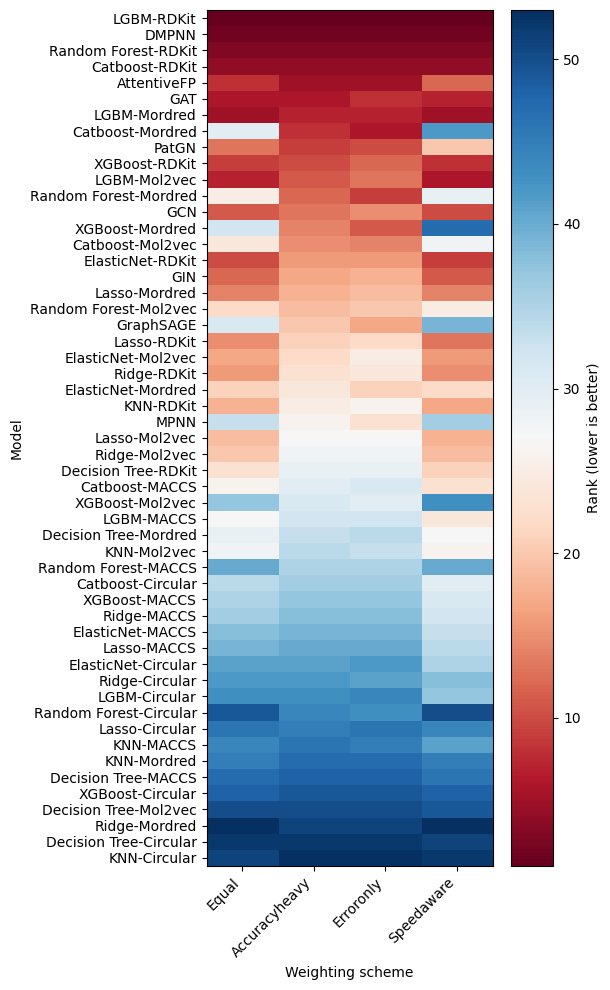

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- SETTINGS ---
font_size   = 10            # overall font size
cmap_choice = "RdBu"   # "RdBu", "bwr", "cividis", "plasma", "Spectral", "coolwarm", "viridis_r", etc.
gap_width   = 0.5          # can be float; will be rounded to an integer >= 0
fix_color_scale = True     # set to False to autoscale per figure
label_rotation  = 45       # angle for x-axis labels

# sanitize gap_width -> integer >= 0
gap_width = int(round(gap_width))
gap_width = max(gap_width, 0)

# Load data
df = pd.read_csv("composite_summary_by_model.csv")
schemes = ["equal", "accuracyheavy", "erroronly", "speedaware"]
rank_cols = [f"{s}_rank" for s in schemes]
for c in rank_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# Order rows by primary scheme
primary = "accuracyheavy"
H = df.sort_values(f"{primary}_rank")[["Model"] + rank_cols].set_index("Model")

# Build matrix with adjustable gaps (gap_width NaN columns between real columns)
data = H.values
rows, cols = data.shape
gap_cols = cols + (cols - 1) * gap_width
matrix = np.full((rows, gap_cols), np.nan, dtype=float)

for j in range(cols):
    matrix[:, j * (gap_width + 1)] = data[:, j]

# Optional: fix color scale across runs (rank 1..max_rank)
vmin = 1
vmax = int(np.nanmax(matrix)) if fix_color_scale else None

plt.figure(figsize=(6, max(8, min(10, 0.25 * len(H)))))
im = plt.imshow(matrix, aspect="auto", cmap=cmap_choice, vmin=vmin, vmax=vmax)

# Colorbar
cbar = plt.colorbar(im, label="Rank (lower is better)")
cbar.ax.tick_params(labelsize=font_size)

# X-axis ticks at real columns only, rotated
xticks = np.arange(0, gap_cols, gap_width + 1)
plt.xticks(xticks, [s.capitalize() for s in schemes],
           fontsize=font_size, rotation=label_rotation, ha="right")

# Y-axis labels
plt.yticks(np.arange(len(H.index)), H.index, fontsize=font_size)

# Titles and labels
####plt.title("Model ranks across weighting schemes (heatmap)", fontsize=font_size + 2)
plt.xlabel("Weighting scheme", fontsize=font_size)
plt.ylabel("Model", fontsize=font_size)

plt.tight_layout()
plt.show()
